<div style="background-color:#000;"><img src="pqn.png"></img></div><div><a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://www.pyquantnews.com/getting-started-with-python-for-quant-finance/">get started with Python for quant finance</a>. For educational purposes. Not investment advice. Use at your own risk.</div>

## Library installation

Install the third-party libraries used in this notebook so you can reproduce the data pull and calculations locally.

In [ ]:
!pip install yfinance numpy pandas matplotlib

We call `returns.hist()` later, which relies on pandas’ plotting integration (and matplotlib under the hood) even though pandas isn’t explicitly imported in the code.

## Imports and setup

We use NumPy (`numpy`) for numeric utilities like `np.nan`, and yfinance (`yfinance`) to download AAPL price history directly into a pandas DataFrame.

In [1]:
import numpy as np
import yfinance as yf

## Download prices and compute returns

Pull AAPL daily price data for a fixed window and convert the Close series into simple daily returns for distribution-based analysis.

In [2]:
data = yf.download("AAPL", start="2020-01-01", end="2021-12-31")

/var/folders/6m/0ykpdmvn3lb5qkq15hk3s11c0000gn/T/ipykernel_76741/1900998631.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2021-12-31")
[*********************100%***********************]  1 of 1 completed


In [14]:
closes = data.Close
returns = closes.pct_change().AAPL

Using percent-change returns (not cumulative PnL) keeps the distribution interpretable, which matters when we care about tails instead of just a single summary metric. In real research you’d usually drop the first NaN return and confirm the index has trading-day frequency before comparing metrics across assets.

## Implement the Omega ratio function

Define Omega so we can score a return stream by comparing “gains above a hurdle” to “losses below it,” without assuming normality.

In [16]:
def omega_ratio(returns, required_return=0.0):
    """Determines the Omega ratio of a strategy.

    Parameters
    ----------
    returns : pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    required_return : float, optional
        Minimum acceptance return of the investor. Threshold over which to
        consider positive vs negative returns. It will be converted to a
        value appropriate for the period of the returns. E.g. An annual
        minimum acceptable return of 100 will translate to a minimum
        acceptable return of 0.018.

    Returns
    -------
    omega_ratio : float

    Note
    -----
    See <https://en.wikipedia.org/wiki/Omega_ratio> for more details.
    """
    return_threshold = (1 + required_return) ** (1 / 252) - 1

    returns_less_thresh = returns - return_threshold

    numer = sum(returns_less_thresh[returns_less_thresh > 0.0])
    denom = -1.0 * sum(returns_less_thresh[returns_less_thresh < 0.0])

    if denom > 0.0:
        return numer / denom
    return np.nan

The key professional habit here is matching units: we pass an annual hurdle rate but convert it to a daily threshold so we’re not mixing frequencies. Omega’s numerator/denominator construction makes tail behavior show up naturally, since large downside days can dominate the shortfall even when average returns look fine.

## Diagnose tails and compute Omega

Visualize and summarize the return distribution, then compute Omega for a realistic hurdle rate to see how upside compares to shortfall.

<Axes: >

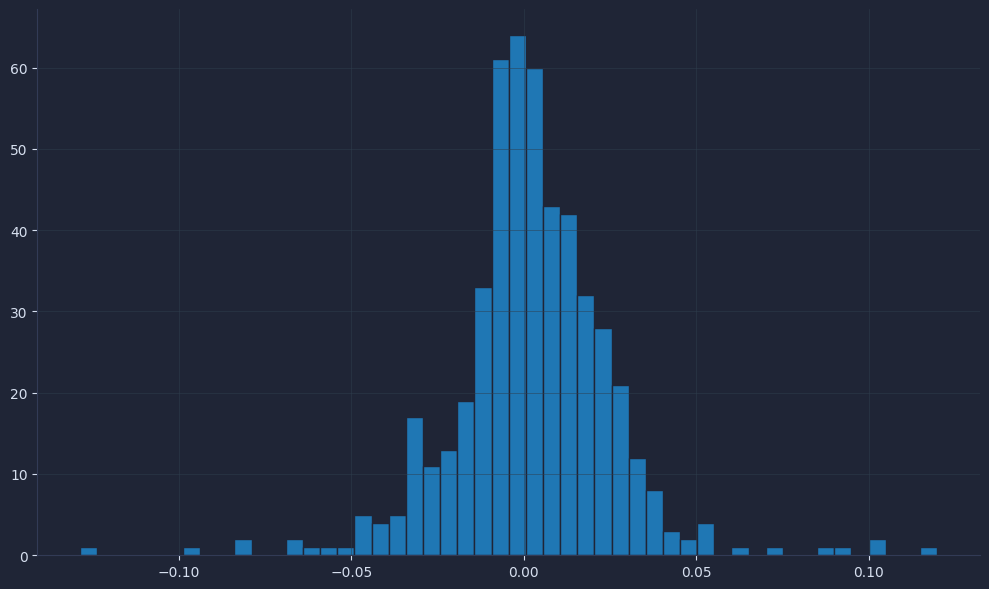

In [17]:
returns.hist(bins=50)

In [18]:
returns.skew()
returns.kurtosis()

np.float64(5.349584563721581)

In [20]:
omega_ratio(returns)

1.28306648583603

The histogram plus skew/kurtosis is the “distribution check” loop that keeps us from over-trusting Sharpe when returns are lopsided or fat-tailed. Omega then turns that same distribution into a hurdle-aware performance number, which is exactly the point of moving beyond single-moment metrics when downside surprises matter.

<a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://www.pyquantnews.com/getting-started-with-python-for-quant-finance/">get started with Python for quant finance</a>. For educational purposes. Not investment advice. Use at your own risk.